# Scooby Evaluator

## General Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [62]:
adata_counts

AnnData object with n_obs × n_vars = 62550 × 5006
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'region', 'z_level', 'cell_labels', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'outlier', 'leiden', 'x', 'y'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'split', 'gene_name'
    uns: 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'spatial_neighbors', 'spatialdata_attrs', 'umap'
    obsm: 'X_banksy', 'X_banksy_0.2', 'X_banksy_0.8', 'X_npca', 'X_pca', 'X_pca_train', 'X_pca_train_scaled', 'X_umap', 'cell_batch', 'spatial'
    layers: 'l

In [2]:
import os

import numpy as np
import pandas as pd
import scipy
import torch
import tqdm
from accelerate import Accelerator
from peft import LoraConfig, get_peft_model

from torch.utils.data import DataLoader

from enformer_pytorch.data import GenomeIntervalDataset

import scanpy as sc

from scooby.modeling import Scooby
from scooby.data import onTheFlyDataset, onTheFlyPseudobulkDataset
from scooby.utils.utils import fix_rev_comp_multiome, undo_squashed_scale, get_pseudobulk_count_pred,get_gene_slice_and_strand

2025-04-10 18:04:23.235054: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-10 18:04:23.247889: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-10 18:04:23.251818: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-10 18:04:23.262059: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-10 18:04:24.989871: W tensorflow/compiler/tf2

In [3]:
from scooby.utils.utils import process_count

In [4]:
data_path = '/s/project/QNA/seq2space/data/'

## scooby

### Functions for Pearson correlation

In [5]:
def stack_and_pearson(x,y):
    return torch.corrcoef(torch.stack([x,y]))[0,1]
batched_pearson = torch.vmap(stack_and_pearson, chunk_size=1)

def predict(model, seqs, seqs_rev_comp, conv_weights, conv_biases, bins_to_predict = None):
    bs = seqs.shape[0]
    # assert bs == 1
    with torch.no_grad():
        with torch.autocast("cuda"):
            outputs = model.forward_sequence_w_convs(seqs, conv_weights, conv_biases, bins_to_predict = bins_to_predict)
            if bins_to_predict is not None:
                outputs_rev_comp = model.forward_sequence_w_convs(seqs_rev_comp, conv_weights, conv_biases, bins_to_predict = (6143 - bins_to_predict))
            else:
                outputs_rev_comp = model.forward_sequence_w_convs(seqs_rev_comp, conv_weights, conv_biases, bins_to_predict = None)
    flipped_version = torch.flip(outputs_rev_comp,(1,-3))
    # outputs_rev_comp_test = fix_rev_comp_multiome(flipped_version) #fix_rev_comp2(flipped_version)
    return (outputs + flipped_version)/2

### Load the model

In [6]:
accelerator = Accelerator(step_scheduler_with_optimizer = False)

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


#### Option 1: Load pretrained scooby from the hub

#### Option 2: Load self-trained scooby checkpoint, un-lora it, and save it

In [7]:
import safetensors
from borzoi_pytorch.config_borzoi import BorzoiConfig
from scooby.utils.utils import get_lora
#Initialize the config
config = BorzoiConfig.from_pretrained("johahi/flashzoi-replicate-0")
config.count_mode = "TSS"
csb = Scooby.from_pretrained(
        'johahi/flashzoi-replicate-0',
        config = config,
        cell_emb_dim=100,
        embedding_dim=1920,
        n_tracks=1,
        return_center_bins_only=True,
        disable_cache=False,
        use_transform_borzoi_emb=False,
        count_only=True
    )
# we have to make the lora version, load the weights, and merge the lora weights back into scooby
csb = get_lora(csb, train=False)
print (safetensors.torch.load_model(csb,'/s/project/QNA/seq2space/tmp/spatial_scooby_epoch_21_1000_spatial_scooby_run/model.safetensors')) 
csb = csb.merge_and_unload()

# If you want to save the model to load it quicker next time
# csb.save_pretrained('test_scooby_checkpoint')
# can be then loaded with 
# scooby = Scooby.from_pretrained('test_scooby_checkpoint', cell...)

Some weights of Scooby were not initialized from the model checkpoint at johahi/flashzoi-replicate-0 and are newly initialized: ['cell_state_to_conv.0.bias', 'cell_state_to_conv.0.weight', 'cell_state_to_conv.2.bias', 'cell_state_to_conv.2.weight', 'cell_state_to_conv.5.bias', 'cell_state_to_conv.5.weight', 'cell_state_to_conv.8.bias', 'cell_state_to_conv.8.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(set(), [])


### Specify genome

In [8]:
gtf_file = os.path.join("/s/project/QNA/seq2space/laika_training_data/gencode.vM25.annotation.gtf.gz")
fasta_file = os.path.join('/s/project/QNA/seq2space/data/GRCm38.p6.genome.fa')
bed_file = os.path.join("/s/project/QNA/seq2space/laika_training_data/genes_centered.bed")

### Load neighbors and embedding

In [9]:
adata_counts_path = "/s/project/QNA/seq2space/data/Xenium_Mouse_Brain_Processed_borz.h5ad"
adata_counts = sc.read_h5ad(adata_counts_path)

In [10]:
adata_counts

AnnData object with n_obs × n_vars = 62550 × 5006
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'region', 'z_level', 'cell_labels', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'outlier', 'leiden', 'x', 'y'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'split', 'gene_name'
    uns: 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'spatial_neighbors', 'spatialdata_attrs', 'umap'
    obsm: 'X_banksy', 'X_banksy_0.2', 'X_banksy_0.8', 'X_npca', 'X_pca', 'X_pca_train', 'X_pca_train_scaled', 'X_umap', 'cell_batch', 'spatial'
    layers: 'l

In [11]:
adata_aggregated = sc.get.aggregate(adata_counts, by="leiden", func="sum", layer="log")

In [12]:
adata_aggregated

AnnData object with n_obs × n_vars = 39 × 5006
    obs: 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'split', 'gene_name'
    layers: 'sum'

In [13]:
adata_aggregated.obs.leiden.tolist()

['0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38']

In [14]:
cell_type_index = {"celltype": adata_aggregated.obs.leiden.tolist(),
                   "cellindex": [np.where(adata_counts.obs.leiden == x)[0] for x in adata_aggregated.obs.leiden.tolist()],
                   "size": [len(np.where(adata_counts.obs.leiden == x)[0]) for x in adata_aggregated.obs.leiden.tolist()]
                  }

In [15]:
cell_type_index = pd.DataFrame(cell_type_index)

## Eval on Val

### Sequence dataloader 

This only loads the sequences in the right order

In [26]:
gtf_file = '/s/project/QNA/seq2space/laika_training_data/gencode.vM25.annotation.gtf.gz'

In [27]:
from scooby.utils.transcriptome import Transcriptome

In [28]:
transcriptome = Transcriptome(gtf_file)

In [29]:
fasta_file

'/s/project/QNA/seq2space/data/GRCm38.p6.genome.fa'

In [30]:
pd.read_table("/s/project/QNA/seq2space/laika_training_data/genes_centered.bed")

,chr1,2974948,3171556,ENSMUSG00000102693,+,fold3
0,chr1,3003711,3200319,ENSMUSG00000064842,+,fold3
1,chr1,3154452,3351060,ENSMUSG00000102851,+,fold3
2,chr1,3368282,3564890,ENSMUSG00000089699,+,fold3
3,chr1,3433490,3630098,ENSMUSG00000103147,+,fold3
4,chr1,3581850,3778458,ENSMUSG00000102348,+,fold3
...,...,...,...,...,...,...
55347,chrY,90433341,90629949,ENSMUSG00000100964,-,-1
55348,chrY,90507560,90704168,ENSMUSG00000099619,-,-1
55349,chrY,90569321,90765929,ENSMUSG00000099399,-,-1
55350,chrY,90657163,90853771,ENSMUSG00000095366,-,-1


In [31]:
pd.read_table("/s/project/QNA/seq2space/laika_training_data/genes_centered.bed" , header =None, names = ["Chr", "Start", "End", "Gene", "Strand", "Set"]).query("Set == 'fold3'").to_csv('/s/project/QNA/seq2space/laika_training_data/genes_centered_test_only.bed', sep = '\t', index = None, header= None)

In [32]:
import polars as pl
context_length = 524288
filter_val = lambda df: df.filter(True)#
val_ds = GenomeIntervalDataset(
    bed_file = '/s/project/QNA/seq2space/laika_training_data/genes_centered_test_only.bed',
    fasta_file = fasta_file,
    filter_df_fn = lambda df: df.filter((pl.col('column_2') >=0) & (pl.col('column_4').is_in(adata_counts.var_names))), 
    return_seq_indices = False,
    shift_augs = (0,0),
    rc_aug = False,
    return_augs = True,
    context_length = context_length,
    chr_bed_to_fasta_map = {}
)
len(val_ds)

480

In [33]:
clip_soft=  5
val_dataset = onTheFlyDataset(
    None,
    None,
    None, 
    embedding=pd.DataFrame({ 'embedding': [row for row in adata_counts.obsm["X_banksy_0.2"]]}), 
    ds=val_ds,
    get_targets= False,
    random_cells = False,
    cells_to_run = None, 
    clip_soft = clip_soft,
    )
val_loader = DataLoader(val_dataset, batch_size=1, shuffle = False, num_workers = 1)
csb, val_loader = accelerator.prepare(csb, val_loader)

### Get cell conv_weights for all cells

In [34]:
csb.eval()
cell_indices_ct  = []
size_factors_per_ct = []
for _, row in tqdm.tqdm(cell_type_index.iterrows(),disable = True):
    cell_indices_ct.append(
        torch.from_numpy(
            np.vstack(
                adata_counts.obsm["X_banksy_0.2"][row['cellindex'], :] # gets embeddings of all cells of the cell type
                )
            ).unsqueeze(0)
        ) # prep cell_embeddings

cell_indices_niche  = []
size_factors_per_ct = []
for _, row in tqdm.tqdm(cell_type_index.iterrows(),disable = True):
    cell_indices_niche.append(
        torch.from_numpy(
            np.vstack(
                adata_counts.obsm["X_banksy_0.2"][row['cellindex'], :] # gets embeddings of all cells of the cell type
                )
            ).unsqueeze(0)
        ) # prep cell_embeddings

# get conv weights and biases for all cells sorted by cell type in a list
cell_emb_conv_weights_and_biases = []
for cell_emb_idx in tqdm.tqdm(zip(cell_indices_ct, cell_indices_niche), disable = True):
    cell_emb_idx = torch.cat([cell_emb_idx[0], cell_emb_idx[1]], dim=2).to(torch.float).cuda()
    cell_emb_conv_weights,cell_emb_conv_biases = csb.forward_cell_embs_only(cell_emb_idx)
    cell_emb_conv_weights_and_biases.append((cell_emb_conv_weights.to(torch.float16), cell_emb_conv_biases.to(torch.float16)))


### Get counts over exons

In [50]:
num_neighbors = 1

all_outputs, all_targets = [], []
genes = []

# iterate over all gene sequences
for i,x in tqdm.tqdm(enumerate(val_loader), disable = False, total=len(val_dataset)):
    #gene_slice, strand = get_gene_slice_and_strand(transcriptome, val_dataset_targets.genome_ds.df[i, 'column_4'], val_dataset_targets.genome_ds.df[i, 'column_2'], span = False)
    # gene_slice = [0,1]
    # continue
    #targets = (next(val_dataset_target_loader)[2]).float().cuda()
    genes.append(val_dataset.genome_ds.df[i, 'column_4'])
    bs = x[0].shape[0]
    seqs = x[0].cuda().permute(0,2,1)
    stacked_outputs = []
    # break

    stacked_outputs = get_pseudobulk_count_pred(
        csb = csb, 
        seqs = seqs, 
        cell_emb_conv_weights_and_biases = cell_emb_conv_weights_and_biases, 
        gene_slice = torch.Tensor([3071,3072]).to(torch.int),
        strand = None, 
        model_type = "count",
        predict = predict,  
        clip_soft = clip_soft, 
        num_neighbors = 1,
        process_counts=False
    )
    # break
    temp_stack = []
    all_outputs.append(stacked_outputs)
    """
    if strand == '+':
        all_targets.append(undo_squashed_scale(targets[0, gene_slice, ::2], clip_soft=384).sum(axis=0).detach().clone().cpu().squeeze())
    elif strand == '-':
        all_targets.append(undo_squashed_scale(targets[0, gene_slice, 1::2], clip_soft=384).sum(axis=0).detach().clone().cpu().squeeze())
    # if i == 100:
    #     break
    """
all_outputs = torch.vstack(all_outputs).clone().numpy(force=True)

100%|██████████| 480/480 [02:10<00:00,  3.67it/s]


In [51]:
all_targets = adata_aggregated[cell_type_index.celltype.tolist(), genes].layers["sum"].T.copy()

Text(0, 0.5, 'Target')

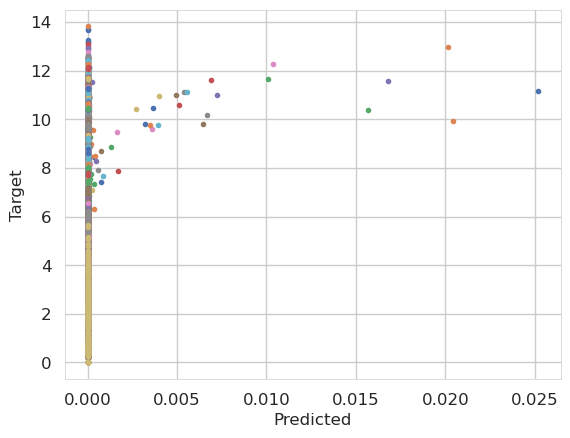

In [52]:
import matplotlib.pyplot as plt
plt.plot(np.log2((all_outputs+1)), np.log2(all_targets+1), '.')
plt.xlabel('Predicted')
plt.ylabel('Target')

In [53]:
spearmanr = [
    scipy.stats.spearmanr(np.log2(all_outputs[:, i] + 1), 
                          np.log2(all_targets[:, i] + 1))[0] for i in range(all_outputs.shape[1])
]
pearsonr =  [
    scipy.stats.pearsonr (np.log2(all_outputs[:, i] + 1), 
                          np.log2(all_targets[:, i] + 1))[0] for i in range(all_outputs.shape[1])]

In [54]:
np.mean(pearsonr), np.median(pearsonr) # np.mean(pearsonr), np.median(pearsonr) with normos (0.8695861071966647, 0.8775566542956221)

(0.07747205610251019, 0.0734742821117539)

Text(0.5, 1.0, 'Count, across gene comparison')

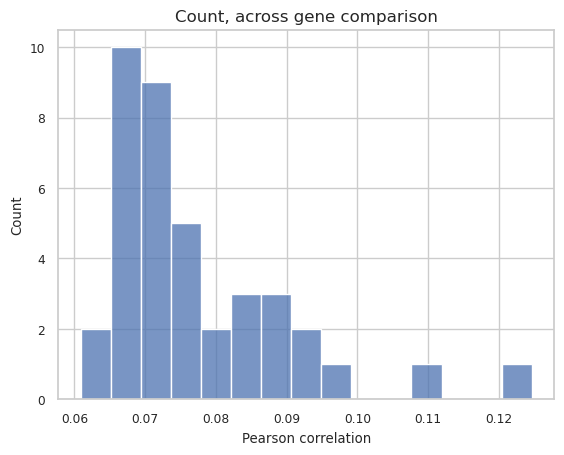

In [55]:
import seaborn as sns
sns.set_theme(style="whitegrid",  font_scale=0.8)
sns.histplot(pearsonr, bins = 15)
plt.xlabel('Pearson correlation')
plt.title('Count, across gene comparison',  size = 12)

In [56]:
# log2(x+1)
counts_predicted_log = np.log2(pd.DataFrame(all_outputs) + 1)  #pd.read_parquet("/data/ceph/hdd/project/node_08/QNA/scborzoi/neurips_bone_marrow/eval/count_predicted_log.parquet")# np.log2(pd.DataFrame(all_outputs) + 1) 
#counts_predicted_log = counts_predicted_log.drop(16, axis = 1) #remove other myloids?
# substract mean per gene across all cell types
counts_predicted_log = counts_predicted_log - counts_predicted_log.mean(axis=0)

#substract mean per cell type across all genes
counts_predicted_log = counts_predicted_log.subtract(counts_predicted_log.mean(axis=1), axis=0)
counts_target_log =np.log2(pd.DataFrame(all_targets) + 1)# pd.read_parquet("/data/ceph/hdd/project/node_08/QNA/scborzoi/neurips_bone_marrow/eval/count_target_log.parquet")# np.log2(pd.DataFrame(all_targets) + 1)
#counts_target_log = counts_target_log.drop(16, axis = 1) #remove other myloids?
counts_target_log = counts_target_log - counts_target_log.mean(axis=0)

counts_target_log = counts_target_log.subtract(counts_target_log.mean(axis=1), axis=0)

In [57]:
import matplotlib as mp
font_size=  12
mp.rcParams['axes.labelsize'] = font_size
mp.rcParams['axes.linewidth'] = font_size / 24.
mp.rcParams['axes.titlesize'] = font_size
mp.rcParams['legend.fontsize'] = font_size
mp.rcParams['xtick.labelsize'] = font_size
mp.rcParams['ytick.labelsize'] = font_size

0.010826328092315554


Text(0.5, 0, 'Predicted')

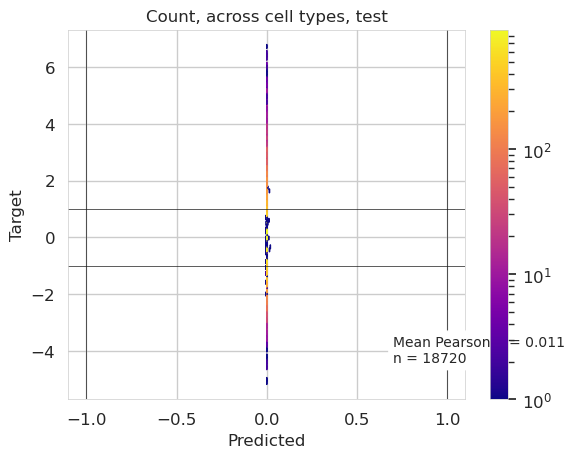

In [58]:
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
ax = plt.hexbin(x=counts_predicted_log.values.ravel(), y=counts_target_log.values.ravel(), mincnt=1, cmap='plasma', norm=LogNorm())
plt.axvline(1, c='k', linewidth = font_size/24)
plt.axvline(-1,c='k', linewidth = font_size/24)
plt.axhline(1,c='k', linewidth = font_size/24)
plt.axhline(-1,c='k', linewidth = font_size/24)
plt.colorbar()
plt.ylabel('Target')
plt.title('Count, across cell types, test')
p=scipy.stats.pearsonr(counts_predicted_log.values.ravel(), counts_target_log.values.ravel())[0]
# plt.text(2.5,-5, f"Pearson corr.: {np.round(p, 3)}", bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))
plt.text(.7,-4.4, f"Mean " + r"Pearson R"+ f" = {p:.3f} \nn = {len(counts_predicted_log.values.ravel())}", bbox=dict(facecolor='white', edgecolor='white', boxstyle='round'), fontdict={'size' : 10})
print(p)
plt.xlabel('Predicted')
#plt.savefig("Fig2E.svg",bbox_inches="tight")

<Axes: >

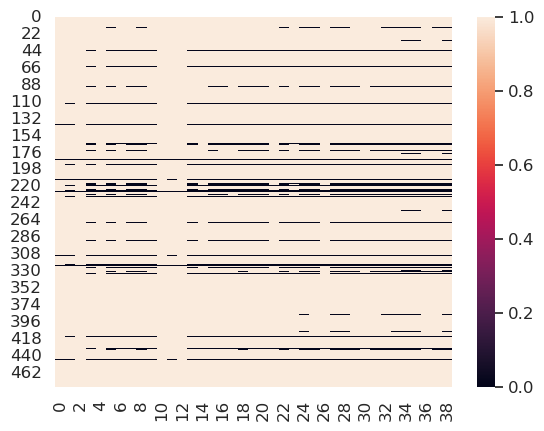

In [60]:
sns.heatmap(all_outputs > 0)

<Axes: >

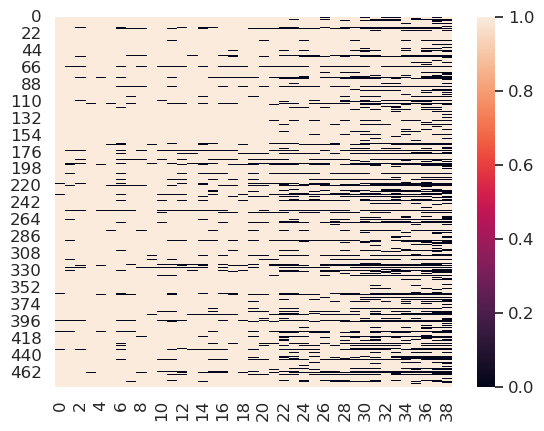

In [61]:
sns.heatmap(all_targets > 0)